# GlycoSHIELD Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

This tutorial shows the basic functionality of GlycoSHIELD, GlycoTRAJ and GlycoSASA.

### GlycoSHIELD
First, we glycosylate a N-cadherin EC5 domain (EC5.pdb), which natively contains three gly- cosylation sites at positions 463, 492 and 533. In the tutorial, we will glycosylate the protein with high-mannose N-glycans (Man5) and visualise the span and shielding of the resulting sugar cover. The necessary glycan conformers are located in the GLYCAN_LIBRARY folder and include Man5.pdb (reference file) and Man5_dt1000.xtc (conformer library sampled at 1000ps intervals). 

Folders containing different glycans have to be downloaded by users to a local directory and unzipped prior to use. [THIS IS NOT REALLYNEEDED ANY MORE - WILL BE AUTO DOWNLOADED].

The prepared input file (EC5_input) manages the glycan grafting:

In [49]:
import warnings
warnings.filterwarnings('ignore')

import nglview as nv
import MDAnalysis as mda
import numpy as np

from glycoshield.lib import glycoshield,glycotraj,glycosasa
from glycoshield.NGL import NGL




In [53]:

path="./tmp_files/"
tutorialpath="./TUTORIAL/"
input = '''#
A 540,541,542 1,2,3 GLYCAN_LIBRARY/Man5.pdb GLYCAN_LIBRARY/Man5.xtc PATH/A_541.pdb PATH/A_541.xtc
A 491,492,493 1,2,3 GLYCAN_LIBRARY/Man5.pdb GLYCAN_LIBRARY/Man5.xtc PATH/A_492.pdb PATH/A_492.xtc
#A 532,533,534 1,2,3 GLYCAN_LIBRARY/Man5.pdb GLYCAN_LIBRARY/Man5.xtc PATH/A_533.pdb PATH/A_533.xtc
'''.replace("PATH/",path)


with open(path+"input_sugaring",'w') as f:
    f.write(input)

To graft glycans at the selected positions, run:

In [54]:
gs = glycoshield(protpdb=tutorialpath+'EC5.pdb',protxtc=None,inputfile=path+'input_sugaring',path=path,skip=10)

occupancy_single = gs.run()
print(occupancy_single)

Structure 0 residue 492: 100%|██████████| 3001/3001 [00:01<00:00, 2485.44it/s]


[[ 218 1172]]


The output states how many glycan frames were grafted at each site (in the same order as in the input file). If protein trajectory is given, this will be reported for each protein frame.

### Visualization
Let's look at the grafted glycan shields:

In [55]:
ngl=NGL(path=path)

# How many glycan conformers to show? (reasonable performance if ~< 100)
showglycanframes = 30

# get the residues and chains:
chainlist=gs.chainlist
reslist=gs.reslist

for (chain,resid) in zip(chainlist,reslist):
    ngl.add_sugar(path+'{}_{}.pdb'.format(chain,resid),path+'{}_{}.xtc'.format(chain,resid),showglycanframes)

    
ngl.subsample()

In [56]:
v1=ngl.build_representation()
v1

#009392 1 A
#d0587e 2 A


NGLWidget()

### Rejection rate vs. protein conformation
If multiple conformations of the same protein are available, GlycoSHIELD can be used to estimate the entropic cost of geometrically blocking certain glycan conformers in each protein conformer. An artificial trajectory EC4_EC5.xtc with corresponding PDB file EC4_EC5.pdb can be used to visualise this functionality. In each consecutive frame, the angle between the two domains is decreased. 



See the input trajectory below:

In [7]:
u = mda.Universe(tutorialpath+'EC4_EC5.pdb',tutorialpath+'EC4_EC5.xtc')
prot = u.select_atoms('protein')
t = nv.MDAnalysisTrajectory(prot)
w = nv.NGLWidget(t)
w

NGLWidget(max_frame=5)

To monitor the number of accepted conformations, the following command should be issued:

In [10]:
# We make sure to set "dryrun" to True - disables production of an output trajectory and instead only displays the number of accepted frames.
# We set "ignorewarn" to True, it ensures the grafting continues even if no conformers can be grafted
gs_multi = glycoshield(protpdb=tutorialpath+'EC4_EC5.pdb',
                 protxtc=tutorialpath+'EC4_EC5.xtc',
                 inputfile=path+'input_sugaring',path=path,
                 dryrun=True,
                 ignorewarn=True)

occupancy_multi = gs_multi.run()
print(occupancy_multi)

Structure 5 residue 533: 100%|██████████| 3001/3001 [00:00<00:00, 4539.13it/s]

[[2645 2214 1695]
 [2645 2214  881]
 [2645 2214  633]
 [2645 2214  519]
 [2644 2210  179]
 [2645 2197  208]]


Knowing the number of all available frames (3000), the number of rejected frames can be then plotted for each sugar:

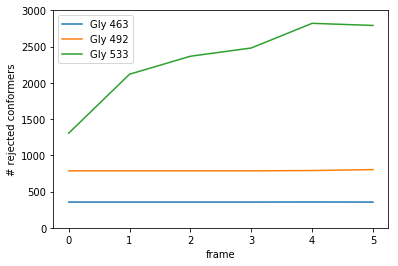

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
for ires in range(len(reslist)):
    plt.plot(3000-occupancy_multi[:,ires],label='Gly {}'.format(reslist[ires]))
plt.ylim(0,3000)
plt.xlabel('frame')
plt.ylabel('# rejected conformers')
plt.legend()


This illustrates that excessive bending of the inter-domain linker results in a rejection of the majority of the conformers and would be thus associated with significant entropic penalty.

### GlycoTRAJ
In order to generate a single trajectory with all glycans mobile, the number of glycan conformers has to be adjusted to be the same across all glycosylation sites, in our first example, 1172 was the largest number of conformers present on all sites.

In [58]:
maxframe=np.min(occupancy_single[0]) 
pdblist=gs.pdblist
xtclist=gs.xtclist
chainlist=gs.chainlist
reslist=gs.reslist
# outname takes the desired root name of the output (the suffix '.xtc' and 'pdb' is appended automatically).
outname=path+"merged_traj"

glycotraj(maxframe,outname,pdblist,xtclist,chainlist,reslist,path=path)

Visualization of the trajectory:

In [59]:
u = mda.Universe(path+'merged_traj.pdb',path+'merged_traj.xtc')
t = nv.MDAnalysisTrajectory(u.atoms)
w = nv.NGLWidget(t)
w

NGLWidget(max_frame=217)

### GlycoSASA
Trajectories containing multiple conformations of single glycans can be used to calculate the shielding score using:

<Figure size 432x288 with 0 Axes>

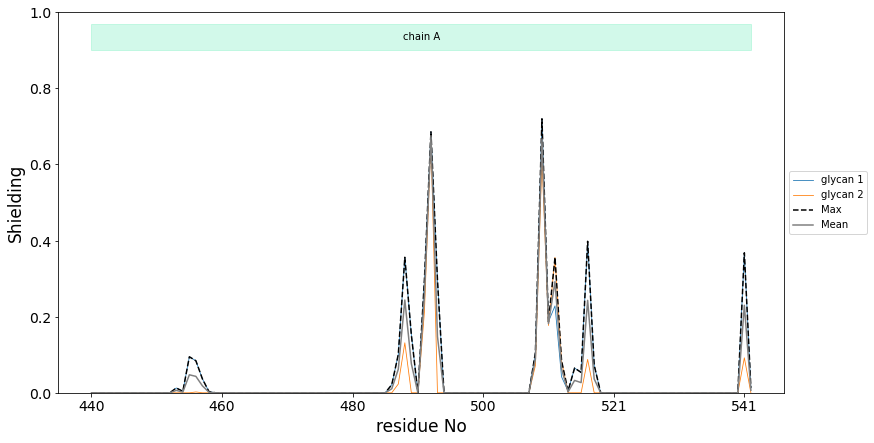

In [60]:
maxframe=np.min(occupancy_single[0]) 
maxframe=10 # temporary
pdblist=gs.pdblist
xtclist=gs.xtclist
probelist=[0.14] # Possibly user will have an option to choose one value, makes it faster and easier to manage visualisation
plottrace=True
ndots=15
mode="max"
keepoutput=False

sasas = glycosasa(pdblist=pdblist,xtclist=xtclist,plottrace=plottrace,
          probelist=probelist,ndots=ndots,mode=mode,keepoutput=keepoutput,maxframe=maxframe,
          path=path)

# This will use 'maxframe' conformers of each glycan to calculate the shielding score. As an output, the user obtains a plot of shielding score along the protein sequence:



In addition, a PDB file is created named “maxResidueSASA_probe_0.14.pdb”, where shielding has been encoded in the column holding the beta factor information. Here, 0.14 denote probe radius used for SASA calculation. A PDB occupancy column equals 0 if a given residue is not accessible at all. 

### Visualization of SASA
Color intensity denotes shielding. Gray=inaccessible.

In [61]:
from glycoshield.NGL import NGLSASA
sasas=np.array(sasas)

myprobe=0.14
occupancy=sasas[sasas[:,4]==myprobe][0,5]
residues=sasas[sasas[:,4]==myprobe][0,0]
sasavis=NGLSASA(path=path,pdbfile='maxResidueSASA_probe_{}.pdb'.format(myprobe),occupancy=occupancy,residues=residues)
v1=sasavis.build_representation()
v1

NGLWidget()

## Download of output files

In the left sidebar of the JupyterLab GUI, please right-click the file you want to download and select *Download*.